# BrisT1D Blood Glucose Prediction

Predicting blood glucose fluctuations is crucial for managing type 1 diabetes.

Developing effective algorithms for this can alleviate some of the challenges faced by individuals with the condition.

Goal: To forecast blood glucose levels one hour ahead using the previous six hours of participasnt data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brist1d/sample_submission.csv
/kaggle/input/brist1d/activities.txt
/kaggle/input/brist1d/train.csv
/kaggle/input/brist1d/test.csv


In [2]:
# plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostRegressor

!pip install --quiet optuna
import optuna

## Functions

In [3]:
### Display Graphs for Null Values

def visualize_null_values(df):

    # Calculate the percentage of null values per feature
    null_percentage = df.isnull().mean() * 100

    # Create categories based on null percentage ranges
    bins = [0, 25, 50, 75, 100]
    labels = ['0-25%', '25-50%', '50-75%', '75-100%']
    category_counts = pd.cut(null_percentage, bins=bins, labels=labels).value_counts().sort_index()

    # Create a figure with two subplots, one for the bar chart and one for the pie chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Bar graph showing number of features in each null percentage category
    bar = ax1.bar(category_counts.index, category_counts.values, color='skyblue')

    # Add numbers on top of each bar
    for i, value in enumerate(category_counts.values):
        ax1.text(i, value + 0.1, str(value), ha='center', fontsize=12)

    ax1.set_title('Features by Percentage of Null Values', fontsize=14)
    ax1.set_xlabel('Percentage of Null Values', fontsize=12)
    ax1.set_ylabel('Number of Features', fontsize=12)

    # Plot 2: Pie chart showing features with null values and without null values
    features_with_nulls = (null_percentage > 0).sum()
    features_without_nulls = (null_percentage == 0).sum()

    labels = ['Features with Null Values', 'Features without Null Values']
    sizes = [features_with_nulls, features_without_nulls]
    colors = ['#ff9999','#66b3ff']

    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Features with and without Null Values', fontsize=14)

    plt.tight_layout()
    plt.show()

### Display Count Plot of Most Common Activity at Each hour

def most_common_activity_per_hour(df):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Most Common Activity at Each Hour', fontsize=16)
    colors = ['blue', 'cyan', 'pink', 'purple', 'red', 'orange']

    for i in range(6):
        row, col_idx = divmod(i, 3)

        top_10_activities = df[f'activity-{i}:00'].value_counts().nlargest(10).index
        filtered_df = df[df[f'activity-{i}:00'].isin(top_10_activities)]

        sns.countplot(filtered_df, x=f'activity-{i}:00', ax=axes[row, col_idx], color=colors[i])
        axes[row, col_idx].set_xticklabels(axes[row, col_idx].get_xticklabels(), rotation=45)
        axes[row, col_idx].set_title(f'Activity at time {i}:00')
        axes[row, col_idx].set_xlabel('Activity')
        axes[row, col_idx].set_ylabel('Count')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Display Boxplots of Blood Glucose Levels for Each Hour and Each Activities

def boxplot_bg_per_hour(h):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=f"activity-{h}:00", y=f"bg-{h}:00", data=train_df)
    plt.xticks(rotation=45)
    plt.title(f"Impact of Activities on Blood Glucose Levels at hour {h}:00")
    plt.xlabel('Activity')
    plt.ylabel('Blood Glucose (mmol/L)')
    plt.show()

### Train Model and Predict

def train_and_predict(model, X_train, y_train, X_test, y_test):
    # train the model
    model.fit(X_train, y_train)

    # predict and evaluate
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    return train_pred, test_pred, train_rmse, test_rmse

## Processing Data

In [4]:
train_df = pd.read_csv('/kaggle/input/brist1d/train.csv')
test_df = pd.read_csv('/kaggle/input/brist1d/test.csv')
sample_submission_df = pd.read_csv('/kaggle/input/brist1d/sample_submission.csv')

/tmp/ipykernel_23/368482172.py:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/brist1d/train.csv')


In [5]:
train_df

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177019,p12_25294,p12,23:35:00,8.8,9.1,9.2,9.4,9.8,10.2,10.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.1
177020,p12_25295,p12,23:40:00,9.1,9.2,9.4,9.8,10.2,10.4,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9
177021,p12_25296,p12,23:45:00,9.2,9.4,9.8,10.2,10.4,10.3,10.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7
177022,p12_25297,p12,23:50:00,9.4,9.8,10.2,10.4,10.3,10.1,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.5


In [6]:
test_df

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
0,p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk
2,p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,p24_256,p24,06:40:00,7.3,7.3,7.1,6.7,6.8,6.8,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3640,p24_257,p24,12:30:00,6.0,6.2,6.2,6.2,5.8,5.5,5.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3641,p24_258,p24,03:45:00,12.4,12.5,12.7,13.1,13.2,13.3,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3642,p24_259,p24,06:10:00,8.3,8.3,8.2,8.2,7.8,7.4,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bg-5:55,149770.0,8.211018,2.852188,2.20,6.1,7.60,9.80,22.2
bg-5:50,158533.0,8.230449,2.913438,2.20,6.1,7.60,9.80,25.1
bg-5:45,163364.0,8.253291,2.945594,2.20,6.1,7.70,9.80,27.8
bg-5:40,149766.0,8.210988,2.852090,2.20,6.1,7.60,9.80,22.2
bg-5:35,158254.0,8.229649,2.911313,2.20,6.1,7.60,9.80,25.1
...,...,...,...,...,...,...,...,...
cals-0:15,141741.0,9.366998,8.023788,0.03,5.6,6.18,9.06,116.1
cals-0:10,141751.0,9.370010,8.021999,0.03,5.6,6.18,9.06,116.1
cals-0:05,141761.0,9.372536,8.023280,0.03,5.6,6.18,9.07,116.1
cals-0:00,141767.0,9.368960,8.023327,0.03,5.6,6.18,9.06,116.1


In [8]:
train_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177024 entries, 0 to 177023
Data columns (total 508 columns):
 #    Column         Non-Null Count   Dtype  
---   ------         --------------   -----  
 0    id             177024 non-null  object 
 1    p_num          177024 non-null  object 
 2    time           177024 non-null  object 
 3    bg-5:55        149770 non-null  float64
 4    bg-5:50        158533 non-null  float64
 5    bg-5:45        163364 non-null  float64
 6    bg-5:40        149766 non-null  float64
 7    bg-5:35        158254 non-null  float64
 8    bg-5:30        163770 non-null  float64
 9    bg-5:25        149763 non-null  float64
 10   bg-5:20        157973 non-null  float64
 11   bg-5:15        164174 non-null  float64
 12   bg-5:10        149771 non-null  float64
 13   bg-5:05        157677 non-null  float64
 14   bg-5:00        164585 non-null  float64
 15   bg-4:55        149780 non-null  float64
 16   bg-4:50        157381 non-null  float64
 17   bg-4:45 

### Changing Participant Number To Be an Integer

In [9]:
train_df['p_num']

0         p01
1         p01
2         p01
3         p01
4         p01
         ... 
177019    p12
177020    p12
177021    p12
177022    p12
177023    p12
Name: p_num, Length: 177024, dtype: object

In [10]:
test_df['p_num']

0       p01
1       p01
2       p01
3       p01
4       p01
       ... 
3639    p24
3640    p24
3641    p24
3642    p24
3643    p24
Name: p_num, Length: 3644, dtype: object

In [11]:
# Change p_num to be integer numbers
train_df['p_num'] = train_df['p_num'].str.extract('(\d+)').astype(int)
test_df['p_num'] = test_df['p_num'].str.extract('(\d+)').astype(int)

In [12]:
train_df['p_num']

0          1
1          1
2          1
3          1
4          1
          ..
177019    12
177020    12
177021    12
177022    12
177023    12
Name: p_num, Length: 177024, dtype: int64

In [13]:
test_df['p_num']

0        1
1        1
2        1
3        1
4        1
        ..
3639    24
3640    24
3641    24
3642    24
3643    24
Name: p_num, Length: 3644, dtype: int64

### Encode Activity Columns

In [14]:
activity_cols = [col for col in train_df.columns if col.startswith('activity')]

After viewing the activities.txt file, I noticed that there are 2 similar activities: "Walk" and "Walking". 
We'll change every occurance of "Walk" to "Walking".

In [15]:
# change every occurance of "Walk" to "Walking" in the activity columns
for col in activity_cols:
    train_df[col] = train_df[col].apply(lambda x: 'Walking' if x == 'Walk' else x)
    test_df[col] = test_df[col].apply(lambda x: 'Walking' if x == 'Walk' else x)

In [16]:
activities = ['No Activity', 'Indoor climbing','Run','Strength training','Swim','Bike','Dancing','Stairclimber','Spinning','Walking','HIIT','Outdoor Bike','Aerobic Workout','Tennis','Workout','Hike','Zumba','Sport','Yoga','Swimming','Weights','Running']
activites_encode = {activity: i for i, activity in enumerate(activities)}
activites_encode

{'No Activity': 0,
 'Indoor climbing': 1,
 'Run': 2,
 'Strength training': 3,
 'Swim': 4,
 'Bike': 5,
 'Dancing': 6,
 'Stairclimber': 7,
 'Spinning': 8,
 'Walking': 9,
 'HIIT': 10,
 'Outdoor Bike': 11,
 'Aerobic Workout': 12,
 'Tennis': 13,
 'Workout': 14,
 'Hike': 15,
 'Zumba': 16,
 'Sport': 17,
 'Yoga': 18,
 'Swimming': 19,
 'Weights': 20,
 'Running': 21}

### Activities Analysis

In [17]:
# Most common activity every 5 minutes
train_df[activity_cols].mode().iloc[0]

activity-5:55    Walking
activity-5:50    Walking
activity-5:45    Walking
activity-5:40    Walking
activity-5:35    Walking
                  ...   
activity-0:20    Walking
activity-0:15    Walking
activity-0:10    Walking
activity-0:05    Walking
activity-0:00    Walking
Name: 0, Length: 72, dtype: object

In [18]:
test_df[activity_cols].mode().iloc[0]

activity-5:55    Walking
activity-5:50    Walking
activity-5:45    Walking
activity-5:40    Walking
activity-5:35    Walking
                  ...   
activity-0:20    Walking
activity-0:15    Walking
activity-0:10    Walking
activity-0:05    Walking
activity-0:00    Walking
Name: 0, Length: 72, dtype: object

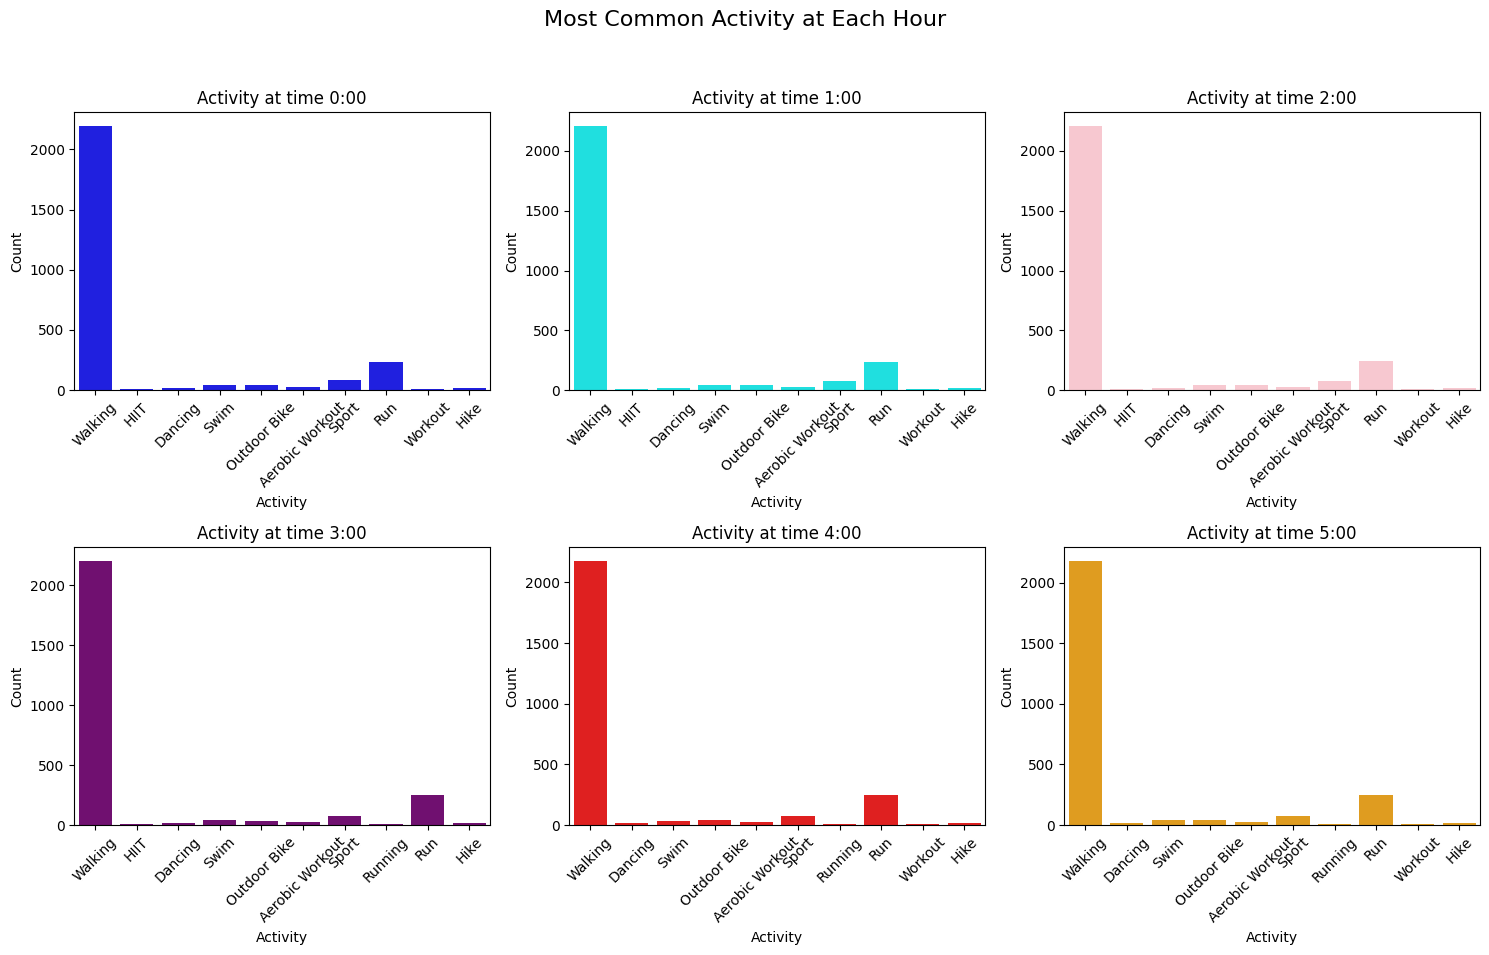

In [19]:
most_common_activity_per_hour(train_df)

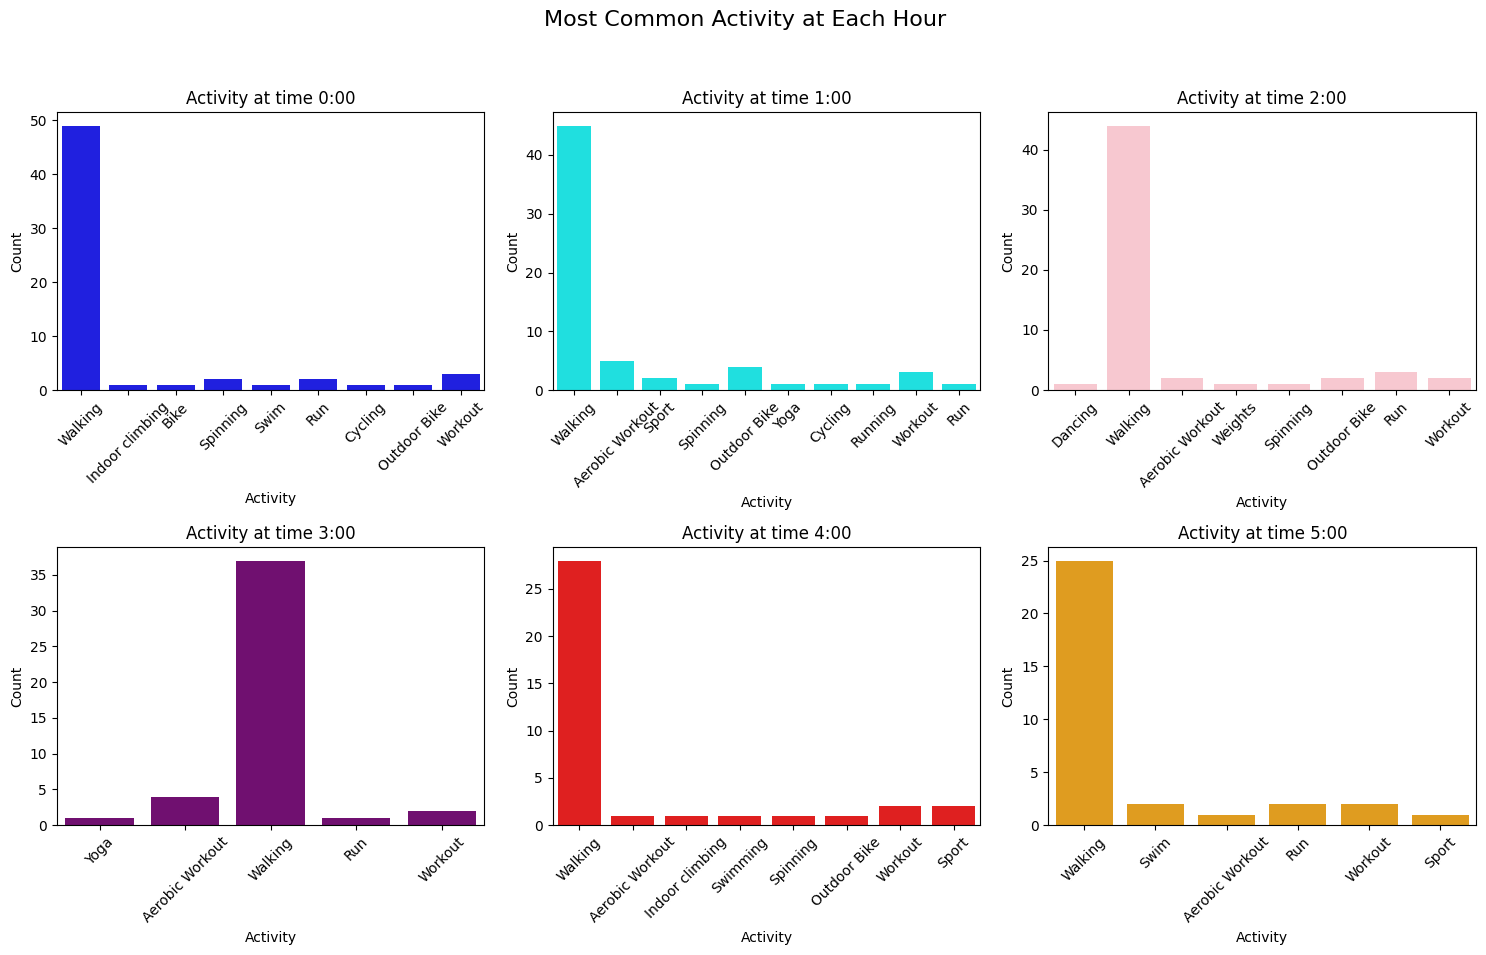

In [20]:
most_common_activity_per_hour(test_df)

## Imputation

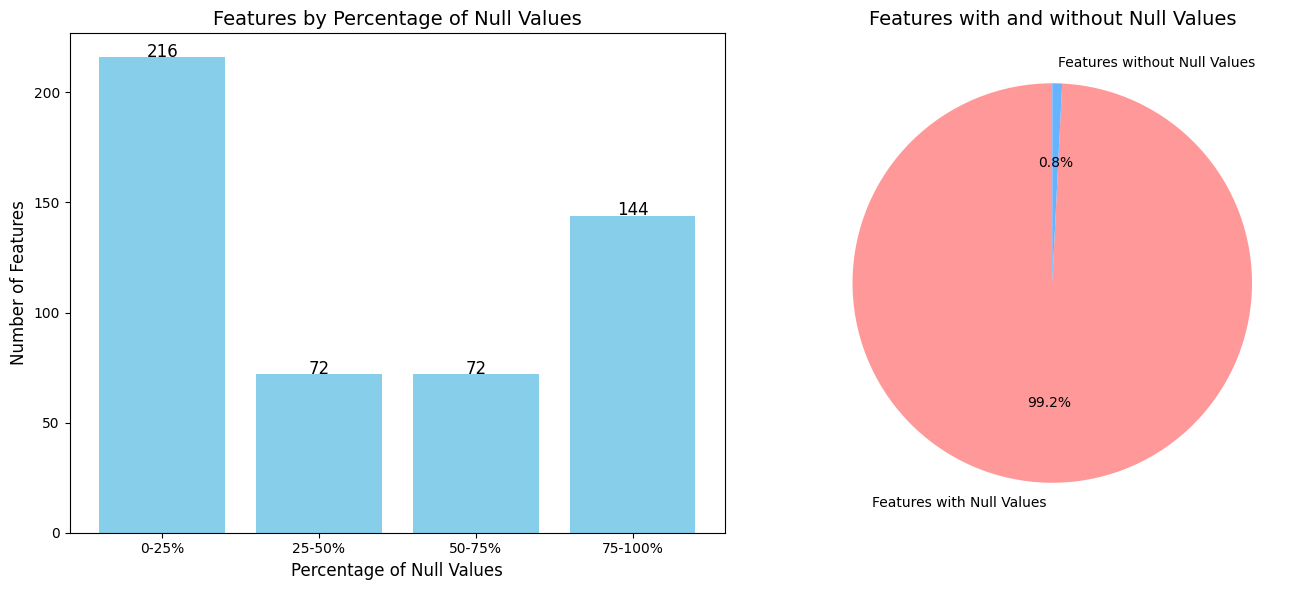

In [21]:
visualize_null_values(train_df)

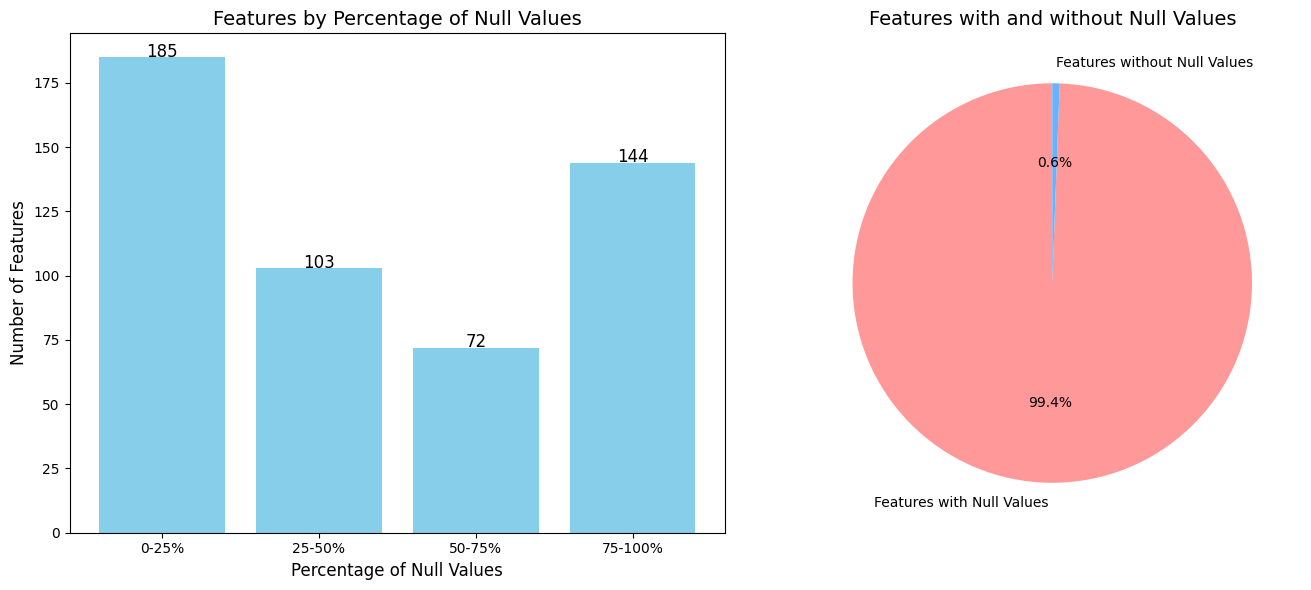

In [22]:
visualize_null_values(test_df)

We'll asume that missing values in the activity columns mean no activity, so the method of imputation for the activity columns

is filling them with "No Activity".

In [23]:
# Apply mapping
for col in activity_cols:
    train_df[col] = train_df[col].apply(lambda x: activites_encode[x] if x in activites_encode else activites_encode['No Activity'])
    test_df[col] = test_df[col].apply(lambda x: activites_encode[x] if x in activites_encode else activites_encode['No Activity'])

In [24]:
# Activity column example of unique values
train_df["activity-5:55"].unique()

array([ 0,  9,  1, 18, 16, 10,  6,  4, 11, 12, 17, 21, 19,  2, 20, 14, 13,
        3,  7,  8, 15,  5])

The chosen method for imputation for the numeric features is forward and backward fill.

This will ensure data continuity by using the previous valid value in a column or row (forward fill),

while backward fill propagates them using the next valid value.

In [25]:
# Impute numeric columns - forward and backward fill
numeric_columns_train = train_df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns_test = test_df.select_dtypes(include=['float64', 'int64']).columns

train_df[numeric_columns_train] = train_df[numeric_columns_train].ffill(axis=1)
train_df[numeric_columns_train] = train_df[numeric_columns_train].bfill(axis=1)
test_df[numeric_columns_test] = test_df[numeric_columns_test].ffill(axis=1)
test_df[numeric_columns_test] = test_df[numeric_columns_test].bfill(axis=1)

In [26]:
print("\nMissing values after forward and backward fill:")
print(train_df[numeric_columns_train].isnull().sum())
print(test_df[numeric_columns_test].isnull().sum())


Missing values after forward and backward fill:
p_num            0
bg-5:55          0
bg-5:50          0
bg-5:45          0
bg-5:40          0
                ..
activity-0:15    0
activity-0:10    0
activity-0:05    0
activity-0:00    0
bg+1:00          0
Length: 506, dtype: int64
p_num            0
bg-5:55          0
bg-5:50          0
bg-5:45          0
bg-5:40          0
                ..
activity-0:20    0
activity-0:15    0
activity-0:10    0
activity-0:05    0
activity-0:00    0
Length: 505, dtype: int64


## Exploratory Data Analysis

### Distribution of Blood Glucose Levels per Hour

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

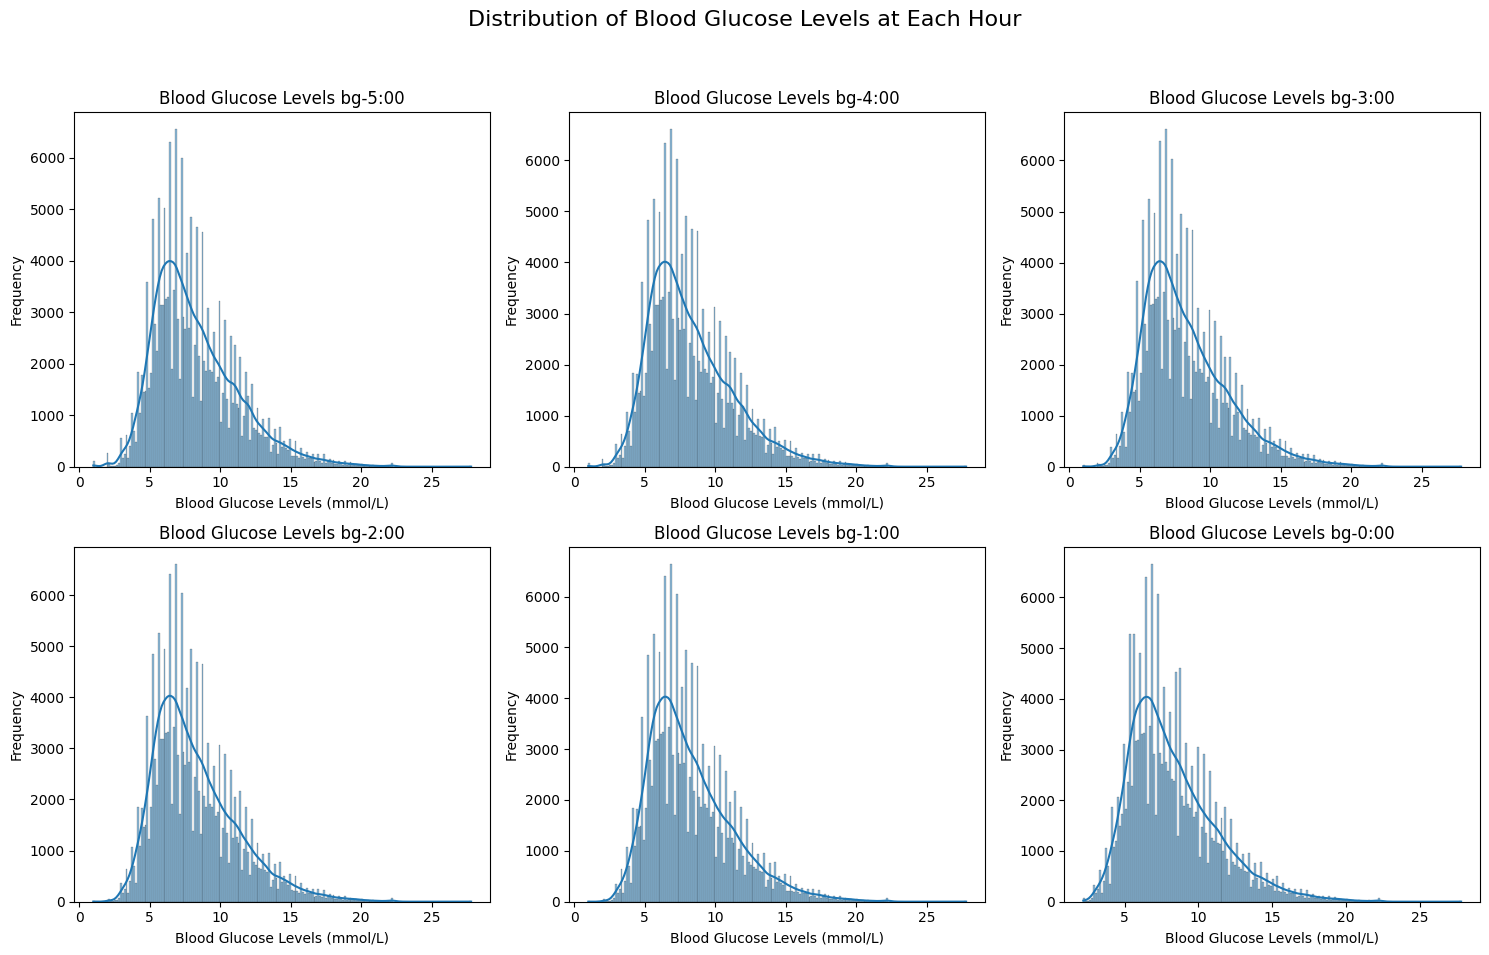

In [27]:
bg_columns = [f'bg-{hour}:00' for hour in range(5, -1, -1)]  # Creates bg-5:00, bg-4:00, ..., bg-0:00

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Distribution of Blood Glucose Levels at Each Hour', fontsize=16)

# Iterate over each column and plot the histogram in the corresponding subplot
for i, col in enumerate(bg_columns):
    row, col_idx = divmod(i, 3)
    sns.histplot(train_df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Blood Glucose Levels {col}')
    axes[row, col_idx].set_xlabel('Blood Glucose Levels (mmol/L)')
    axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see that the distribution of blood glucose levels at each hour is very similar, with very minor differences, meaning they are stable.

This can also suggest that these columns may not be adding unique information to the model, and a subset of them could capture the overall

trend without all six hours of lagged values.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


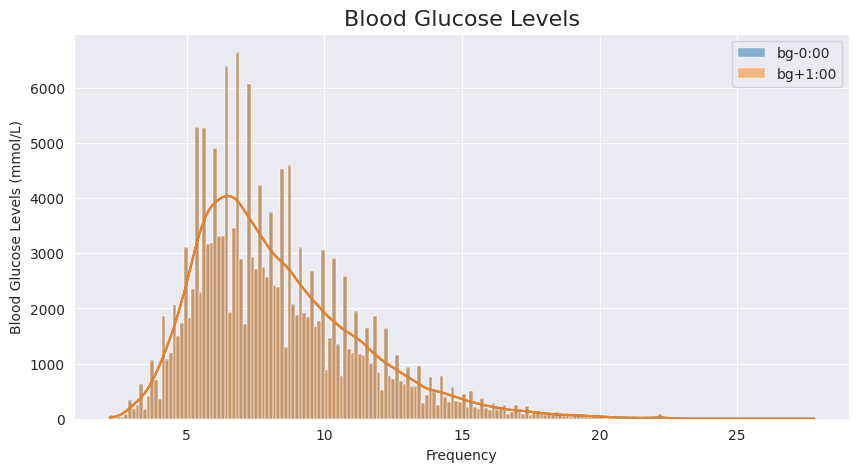

In [28]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.histplot(data=train_df, x="bg-0:00", kde=True, ax=ax, label="bg-0:00")
sns.histplot(data=train_df, x="bg+1:00", kde=True, ax=ax, label="bg+1:00")
ax.set_title("Blood Glucose Levels", fontsize=16)
ax.set_ylabel('Blood Glucose Levels (mmol/L)')
ax.set_xlabel("Frequency")
ax.legend(loc="upper right")

### Activity Influence on Blood Glucose

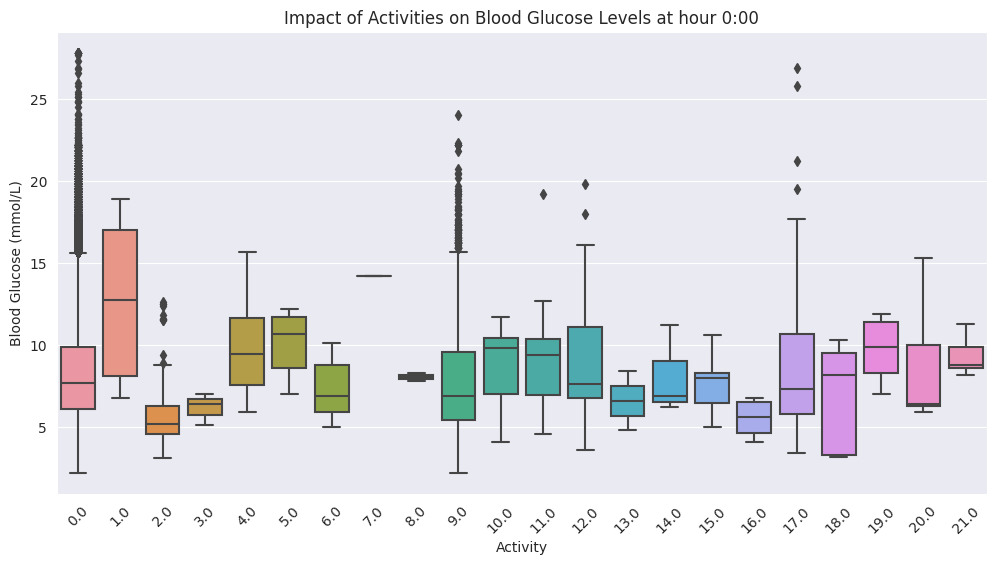

In [29]:
boxplot_bg_per_hour(0)

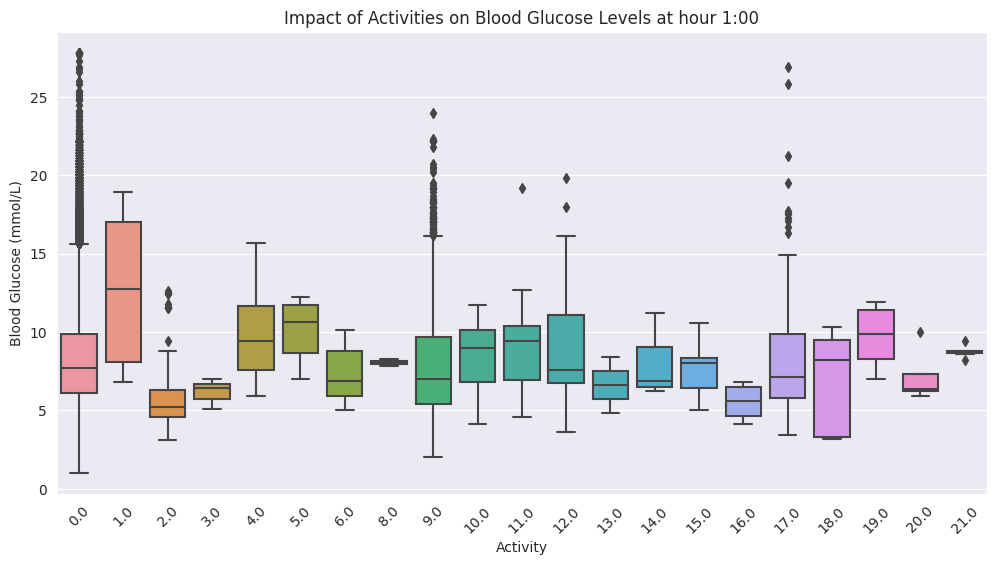

In [30]:
boxplot_bg_per_hour(1)

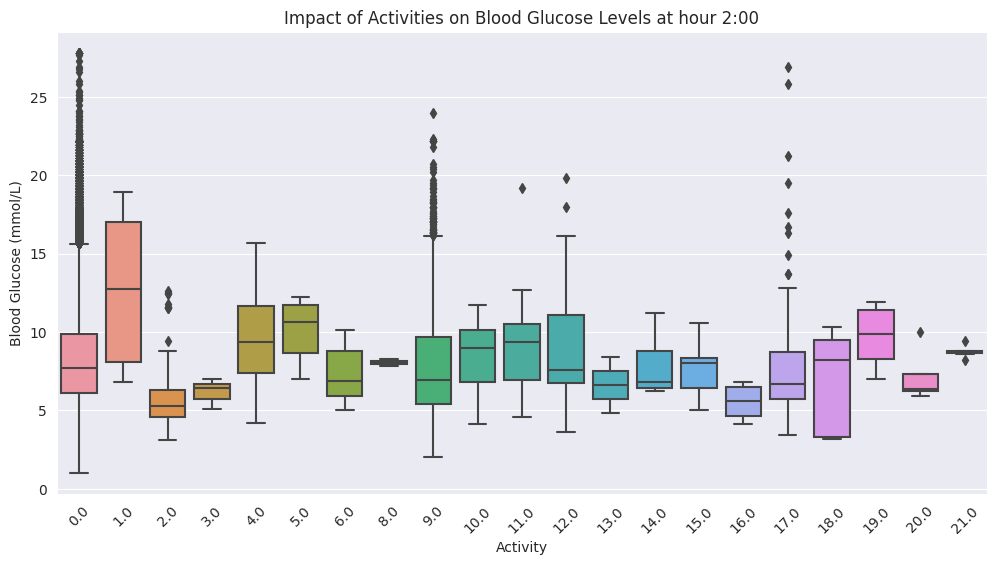

In [31]:
boxplot_bg_per_hour(2)

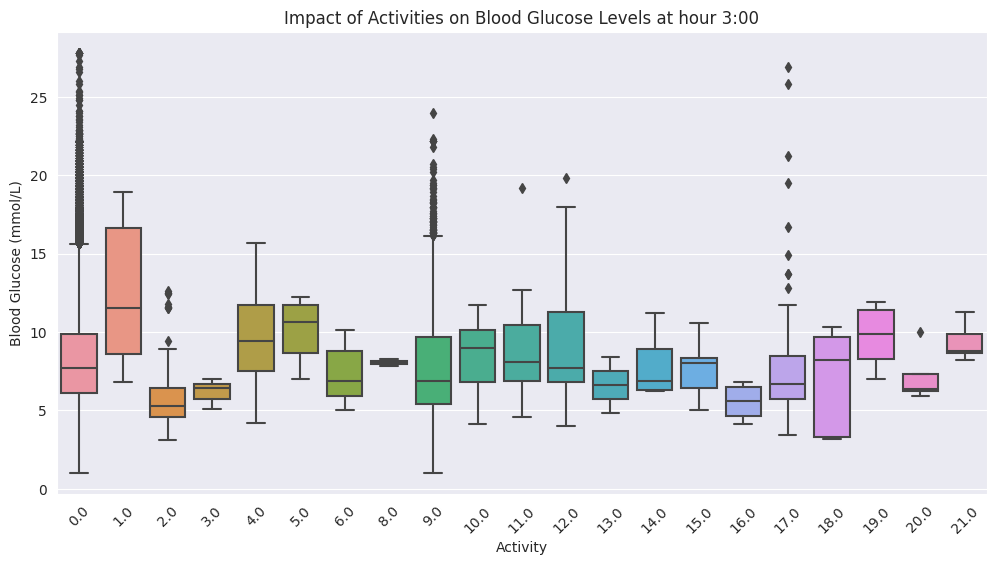

In [32]:
boxplot_bg_per_hour(3)

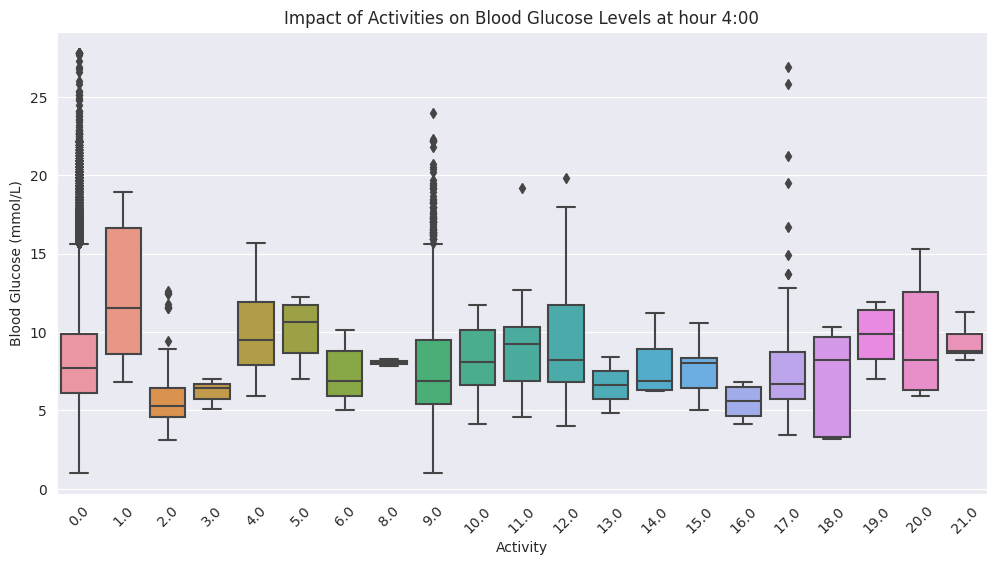

In [33]:
boxplot_bg_per_hour(4)

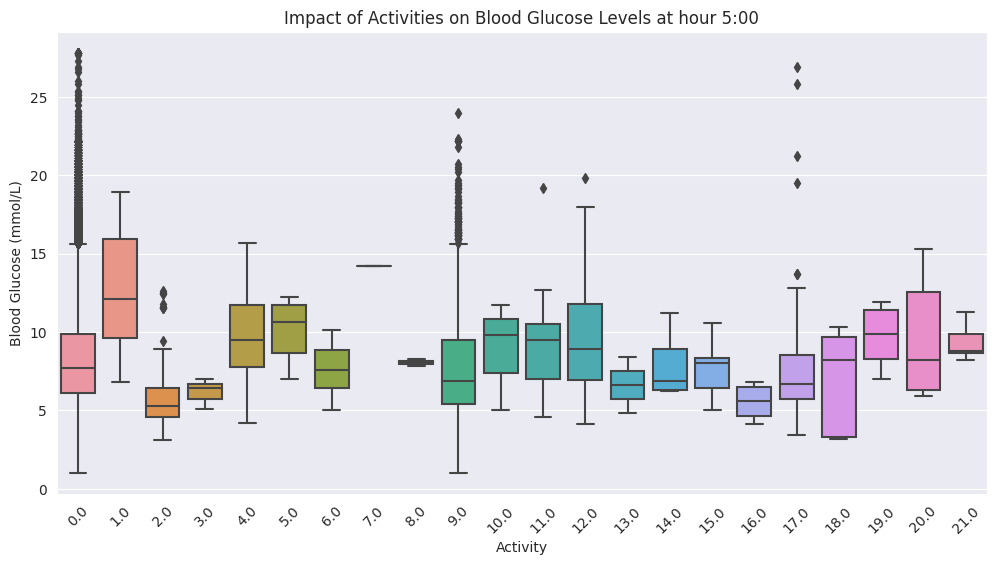

In [34]:
boxplot_bg_per_hour(5)

### Conclusion

From the distribution of blood glucose levles per hour plots we can see that the distribution are quite similar, so we can choose not to use the data with 5 minute gaps, but 1 hour gaps.

Moreover, we can see many high levels of blood glucose in activity 0, which is 'No Activity'. This activity was used to fill null values, and we can see that it makes sence:

blood glucose levels can rise due to no exercise. In addision, participants might eat during that time which can also increase blood glucose levels.

## Feature Selection

For the time based data (bg, insulin, carbs, hr, steps, cals and activity), we'll choose a new gap of 30 minutes, to reduce redundancy.

In [35]:
# changing special characters because some models can't handle them (such as LightGBM)
train_df.columns = train_df.columns.str.replace(":", "-")
test_df.columns = test_df.columns.str.replace(":", "-")

train_df.columns = train_df.columns.str.replace("_", "-")
test_df.columns = test_df.columns.str.replace("_", "-")

sample_submission_df.columns = sample_submission_df.columns.str.replace(":", "-")
sample_submission_df.columns = sample_submission_df.columns.str.replace("_", "-")

In [36]:
# take 30 minutes gap for each column
bg_columns = [f'bg-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
hr_columns = [f'hr-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
insulin_columns = [f'insulin-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
carbs_columns = [f'carbs-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
steps_columns = [f'steps-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
cals_columns = [f'cals-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]
activity_columns = [f'activity-{hour}-{minute:02d}' for hour in range(5, -1, -1) for minute in range(0, 60, 30)]

train_df = train_df[["id", "p-num", "time"] + bg_columns + insulin_columns + carbs_columns + hr_columns + steps_columns + cals_columns + activity_columns + ["bg+1-00"]]
test_df = test_df[["id", "p-num", "time"] + bg_columns + insulin_columns + carbs_columns + hr_columns + steps_columns + cals_columns + activity_columns]

## Feature Engineering

### Time column

Extracting hour, minute, and second as separate features. Also, since time is periodic (e.g., 23:59 is close to 00:00), directly using hour as a numerical feature might misrepresent relationships, so we'll represent it as a cyclic feature using sine and cosine transformations.

The new features are:

`hour_sin`, `hour_cos`, `minute_sin`, `minute cos`, `second_sin`, `second_cos`

In [37]:
# extract hour, minute and second
train_df['hour'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.hour
train_df['minute'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.minute
train_df['second'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.second

test_df['hour'] = pd.to_datetime(test_df['time'], format='%H:%M:%S').dt.hour
test_df['minute'] = pd.to_datetime(test_df['time'], format='%H:%M:%S').dt.minute
test_df['second'] = pd.to_datetime(test_df['time'], format='%H:%M:%S').dt.second

# add cyclic features
train_df['hour-sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour-cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)
train_df['minute-sin'] = np.sin(2 * np.pi * train_df['minute'] / 60)
train_df['minute-cos'] = np.cos(2 * np.pi * train_df['minute'] / 60)
train_df['second-sin'] = np.sin(2 * np.pi * train_df['second'] / 60)
train_df['second-cos'] = np.cos(2 * np.pi * train_df['second'] / 60)

test_df['hour-sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df['hour-cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['minute-sin'] = np.sin(2 * np.pi * test_df['minute'] / 60)
test_df['minute-cos'] = np.cos(2 * np.pi * test_df['minute'] / 60)
test_df['second-sin'] = np.sin(2 * np.pi * test_df['second'] / 60)
test_df['second-cos'] = np.cos(2 * np.pi * test_df['second'] / 60)

/tmp/ipykernel_23/2969196315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.hour
/tmp/ipykernel_23/2969196315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['minute'] = pd.to_datetime(train_df['time'], format='%H:%M:%S').dt.minute
/tmp/ipykernel_23/2969196315.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [38]:
# delete hour column
train_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)
test_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)

/tmp/ipykernel_23/835769752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)
/tmp/ipykernel_23/835769752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['hour', 'minute', 'second', 'time'], inplace=True)


## Model and Prediction

In [39]:
time_columns = ["hour-sin", "hour-cos", "minute-sin", "minute-cos", "second-sin", "second-cos"]
feature_columns = bg_columns + insulin_columns + carbs_columns + hr_columns + steps_columns + cals_columns + activity_columns + time_columns
participant_column = ['p-num']
target_column = ['bg+1-00']

In [40]:
X_train, X_test, y_train, y_test = train_df[feature_columns], test_df[feature_columns], train_df[target_column], sample_submission_df[target_column]

### Cat Boost Model

In [41]:
catboost_model = CatBoostRegressor()

In [42]:
train_pred, test_pred, train_rmse, test_rmse = train_and_predict(catboost_model, X_train, y_train, X_test, y_test)

Learning rate set to 0.092762
0:	learn: 2.8672639	total: 93.5ms	remaining: 1m 33s
1:	learn: 2.7565201	total: 127ms	remaining: 1m 3s
2:	learn: 2.6615511	total: 161ms	remaining: 53.5s
3:	learn: 2.5796042	total: 196ms	remaining: 48.8s
4:	learn: 2.5097484	total: 230ms	remaining: 45.8s
5:	learn: 2.4482004	total: 265ms	remaining: 43.8s
6:	learn: 2.3960673	total: 298ms	remaining: 42.3s
7:	learn: 2.3519983	total: 333ms	remaining: 41.2s
8:	learn: 2.3146385	total: 374ms	remaining: 41.2s
9:	learn: 2.2813551	total: 411ms	remaining: 40.7s
10:	learn: 2.2534312	total: 448ms	remaining: 40.3s
11:	learn: 2.2285648	total: 487ms	remaining: 40.1s
12:	learn: 2.2089295	total: 522ms	remaining: 39.6s
13:	learn: 2.1908054	total: 558ms	remaining: 39.3s
14:	learn: 2.1746753	total: 591ms	remaining: 38.8s
15:	learn: 2.1613891	total: 630ms	remaining: 38.7s
16:	learn: 2.1494797	total: 663ms	remaining: 38.3s
17:	learn: 2.1393332	total: 695ms	remaining: 37.9s
18:	learn: 2.1303001	total: 732ms	remaining: 37.8s
19:	learn

In [43]:
print(f"Train RMSE (CatBoost): {train_rmse:.4f}")
print(f"Test RMSE (CatBoost): {test_rmse:.4f}")

Train RMSE (CatBoost): 1.6030
Test RMSE (CatBoost): 1.5608


#### Hyperparameter Optimization

In [44]:
def objective(trial):
    # Suggest hyperparameters for CatBoost
    params = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Create and train CatBoost model
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Predict on validation set and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [45]:
# Create an Optuna study
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Run optimization for 50 trials

# Best hyperparameters and score
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2024-11-29 21:49:59,275] A new study created in memory with name: no-name-87af6bd5-00f5-40b8-8085-cf7a808ef862
[I 2024-11-29 21:50:12,221] Trial 0 finished with value: 1.5843296978980377 and parameters: {'colsample_bylevel': 0.02457816295320748, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4004406802331465}. Best is trial 0 with value: 1.5843296978980377.
[I 2024-11-29 21:50:31,221] Trial 1 finished with value: 1.494065250807863 and parameters: {'colsample_bylevel': 0.050979836235781326, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 1.494065250807863.
[I 2024-11-29 21:52:36,151] Trial 2 finished with value: 1.4724938083898624 and parameters: {'colsample_bylevel': 0.08254125855825689, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.39725076342114907}. Best is trial 2 with value: 1.4724938083898624.
[I 2024-11-29 21:52:43,075] Trial 3 finished with value: 1.

Best RMSE: 1.2832326660905549
Best hyperparameters: {'colsample_bylevel': 0.09148691884227898, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [46]:
opt_catboost_model = CatBoostRegressor(**study.best_params)

In [47]:
train_pred, test_pred, train_rmse, test_rmse = train_and_predict(opt_catboost_model, X_train, y_train, X_test, y_test)

Learning rate set to 0.092762
0:	learn: 2.9741589	total: 6.27ms	remaining: 6.27s
1:	learn: 2.9646135	total: 12.2ms	remaining: 6.09s
2:	learn: 2.9553488	total: 17.3ms	remaining: 5.76s
3:	learn: 2.9483580	total: 22.8ms	remaining: 5.67s
4:	learn: 2.9367788	total: 28.8ms	remaining: 5.73s
5:	learn: 2.9280711	total: 34.4ms	remaining: 5.7s
6:	learn: 2.9209354	total: 39.5ms	remaining: 5.6s
7:	learn: 2.9163495	total: 44.5ms	remaining: 5.52s
8:	learn: 2.8362088	total: 49.8ms	remaining: 5.48s
9:	learn: 2.8322879	total: 54.9ms	remaining: 5.44s
10:	learn: 2.7909897	total: 60.9ms	remaining: 5.47s
11:	learn: 2.7707925	total: 67ms	remaining: 5.51s
12:	learn: 2.7663483	total: 72.5ms	remaining: 5.5s
13:	learn: 2.7637405	total: 77.8ms	remaining: 5.48s
14:	learn: 2.7637405	total: 81.6ms	remaining: 5.36s
15:	learn: 2.7613119	total: 86.7ms	remaining: 5.33s
16:	learn: 2.7559958	total: 92.3ms	remaining: 5.34s
17:	learn: 2.7525158	total: 97.7ms	remaining: 5.33s
18:	learn: 2.7225136	total: 103ms	remaining: 5.32

In [48]:
print(f"Train RMSE (CatBoost): {train_rmse:.4f}")
print(f"Test RMSE (CatBoost): {test_rmse:.4f}")

Train RMSE (CatBoost): 2.0917
Test RMSE (CatBoost): 1.3264


In [49]:
sample_submission_df.rename(columns={'bg+1-00': 'bg+1:00'}, inplace=True)

In [50]:
sample_submission_df['bg+1:00']=test_pred
sample_submission_df.to_csv('submission.csv', index=False)
sample_submission_df

,id,bg+1:00
0,p01_8459,8.412934
1,p01_8460,5.798467
2,p01_8461,7.743503
3,p01_8462,8.873038
4,p01_8463,6.783308
...,...,...
3639,p24_256,6.129145
3640,p24_257,9.122263
3641,p24_258,7.493281
3642,p24_259,8.329784
